* For a NMF_kl fit on dataset "GTEx", I computed p-value for each component using poisson distribution. There are two ways. One is directly using ```ppois(x, lam)```, the other is ```c*ppois(x-1, lam) + (1-c)*ppos(x,lam), where c ~ U(0,1)```. I call the first one "Poisson p value", the second one "Poisson continuous pvalue" 

* I try to find out those with very big p values

* I compute eigenvalues for the binary matrix with one for each entry with very big p-value (0.999)


## Result:
* the histogram of p-values are shown (cannot display in html so I put the link) https://github.com/zihao12/lowrank-nmf/blob/master/output/gtex_betanmf_K20_pval_poisson.png and https://github.com/zihao12/lowrank-nmf/blob/master/output/gtex_betanmf_K20_pval_poisson_cts.png

* around 1/4 of the genes account for all those big p values; there are quite many samples that also have many big p values

* There is a big eigenvalue of the binary matrix. It is especially big if we compare that with "montoro droplet" dataset result. 


# Compute p-value matrix and plot histogram

In [1]:
source("../code/misc.R")
library(readr)
library(rsvd)


In [2]:
start = proc.time()
dataname = "gtex"
counts = read.csv.matrix(sprintf("../bigdata/%s.csv",dataname))
runtime = proc.time() - start
cat(sprintf("finish reading data after %f seconds\n", runtime[[3]]))
cat(sprintf("dimension of data: n=%d, p = %d\n", dim(counts)[1], dim(counts)[2]))

finish reading data after 228.938000 seconds
dimension of data: n=11688, p = 55863


## what does the data look like

In [3]:
cat("summary")
summary(as.vector(counts))

summary

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
       0        0        1     1080      102 27195665 

In [4]:
cat(sprintf("percentage of 0s: %f", length(counts[counts == 0])/(nrow(counts)*ncol(counts))))

percentage of 0s: 0.484126

So this dataset is quite sparse. It has has some big numbers (not that big compared with GTEx dataset)

## compute pvalue

In [5]:
method = "betanmf"

F = read.csv.matrix(sprintf("../bigdata/%s_factors_%s.csv", dataname, method))
L = read.csv.matrix(sprintf("../bigdata/%s_loadings_%s.csv", dataname, method))
K = ncol(L)

# pval_pois_cts.out.file <- sprintf("%s_%s_K%d_pval_poisson_cts.png",dataname, method, K)
# pval_poisson.out.file <- sprintf("%s_%s_K%d_pval_poisson.png",dataname, method, K)

# main = sprintf("%s on %s with K = %d", method, dataname, K)
# pval_plot_pois_cts(counts, L%*%t(F), pval_pois_cts.out.file, main)
# pval_plot_poisson(counts, L%*%t(F), pval_poisson.out.file, main)



In [ ]:
The poisson pvalue
<img src="gtex_betanmf_K20_pval_poisson.png">

The "continuous" poisson pvalue
<img src="gtex_betanmf_K20_pval_poisson_cts.png">



# See what are those big p-values

In [6]:
pvals_cts <- function(X,Lam){
    set.seed(123)
    n = nrow(X)
    p = ncol(X)
    C = matrix(runif(n*p), nrow = n)
    pvals = C * ppois(X-1, Lam) + (1-C) * ppois(X, Lam)
    return(pvals)
}
Lam = L%*%t(F)
pval = pvals_cts(counts, Lam)


In [12]:
threshold = 0.999
pval_bin = pval > threshold
cat(sprintf("percentage of those have p value > %.3f: %f",threshold, sum(pval_bin)/(nrow(pval)*ncol(pval))))

percentage of those have p value > 0.999: 0.516357

### Those big p values are wide spread across samples and genes
* For each gene, I show for how many entries the fit has p value larger than 0.999. On average there should be around 5000 per gene, and our histogram show around 1/4 genes have more than 10,000 (basically across all samples). 

* Across samples it is more normally distributed, though there are quite many outlier samples that have over 40,000 such entries (around 70% of genes)

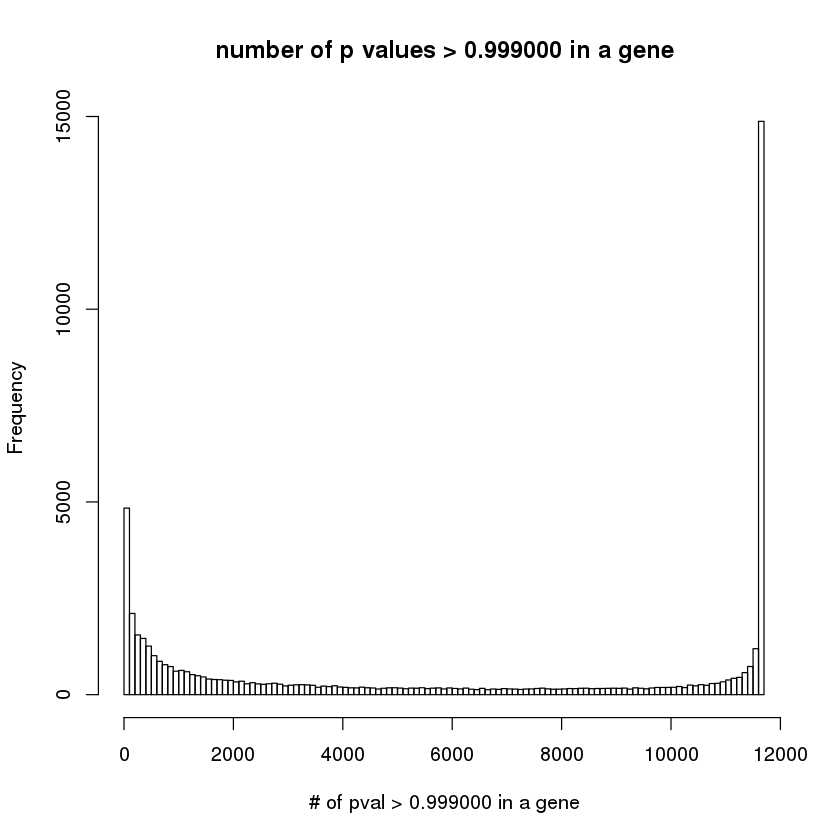

In [13]:
hist(colSums(pval_bin), breaks = 100, xlab = sprintf("# of pval > %f in a gene", threshold), 
     main = sprintf("number of p values > %f in a gene", threshold))

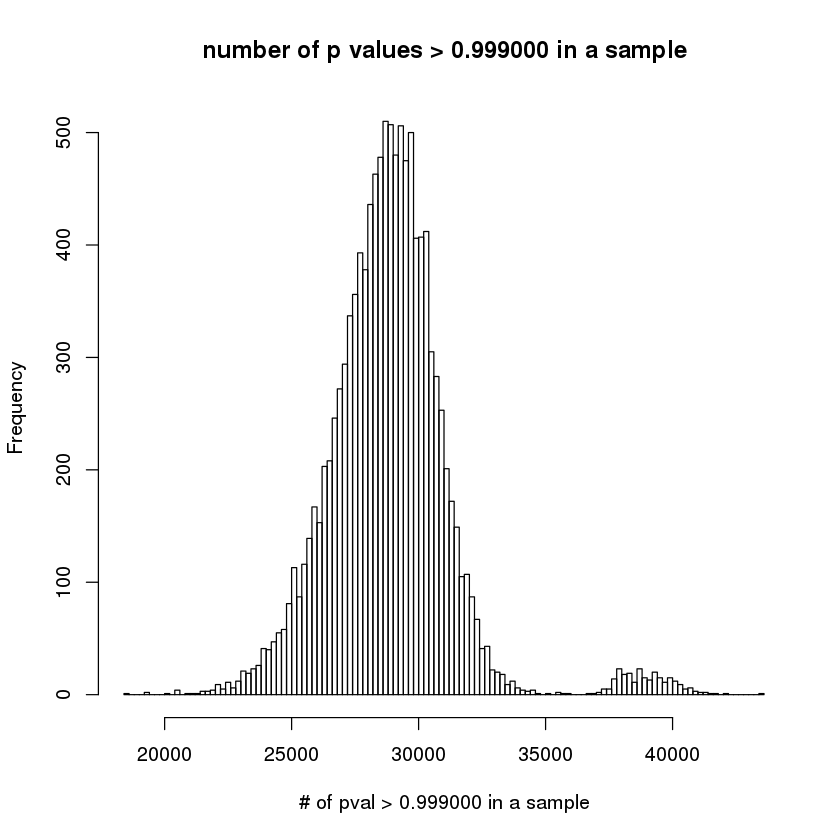

In [14]:
hist(rowSums(pval_bin), breaks = 100, xlab = sprintf("# of pval > %f in a sample", threshold), 
     main = sprintf("number of p values > %f in a sample", threshold))

# Find Eigenvalues of binary matrix

I form a binary matrix of the same size as original data. An ertry is one if the p value is larger than 0.999. Then I compute its eigenvalues. 

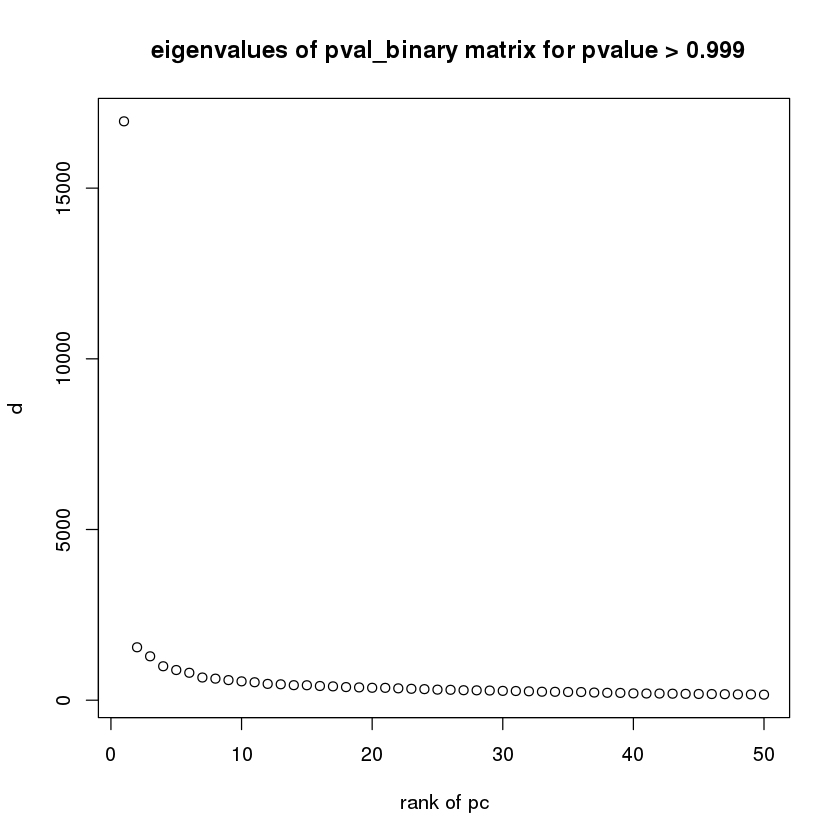

In [15]:
set.seed(12345)
svd_out = rsvd(pval_bin,k = 50)
plot(svd_out$d, xlab = "rank of pc", ylab = "d", 
     main = sprintf(" eigenvalues of pval_binary matrix for pvalue > %.3f", threshold))

In [16]:
print("see the scale of the eigenvalues")
svd_out$d

[1] "see the scale of the eigenvalues"


[1] 16956.5812  1550.2901  1285.7351   994.3298   883.9400   803.3615
 [7]   664.6891   631.5787   589.1888   552.2476   526.0570   478.1092
[13]   465.9227   440.2509   438.0498   416.1994   405.2190   384.2724
[19]   374.5572   363.9677   362.0924   347.2351   334.1649   324.2141
[25]   309.6944   304.7521   292.6933   289.2589   283.1376   273.3477
[31]   269.5173   260.8567   248.4912   245.9118   240.8239   239.0138
[37]   224.1925   216.8173   213.6592   199.7581   195.9737   195.3388
[43]   191.1609   185.8614   183.0204   180.7089   176.0458   170.1287
[49]   169.0267   162.1994